# Examining Point Clouds

This notebook walks through the first default phase of a Spyral pipeline, `PointcloudPhase`. For documentation on the phases, follow this [link](https://attpc.github.io/Spyral/user_guide/phases/about/) to the documentation.

### Imports

First we import all of the necessary modules

In [1]:
from spyral.core.point_cloud import point_cloud_from_get, calibrate_point_cloud_z
from spyral.core.run_stacks import form_run_string
from spyral.trace.get_event import GetEvent, GET_DATA_TRACE_START, GET_DATA_TRACE_STOP
from spyral.trace.trace_reader import create_reader
from spyral.correction import create_electron_corrector
from spyral.core.pad_map import PadMap
from spyral.core.rcnp_map import RcnpMap
from spyral.geometry.circle import generate_circle_points

from spyral import PadParameters, GetParameters, FribParameters, DetectorParameters, DEFAULT_MAP, PointcloudPhase 

import numpy.random as random
import numpy as np
import matplotlib.pyplot as plt
import mplcursors
from pathlib import Path
import h5py as h5

%matplotlib widget

def find_trace_from_padid(event: GetEvent, pad_id: int) -> int:
    for idx, trace in enumerate(event.traces):
        if trace.hw_id.pad_id == pad_id:
            return idx
    return -1

### Configuration

Define your Spyral configuration below. If you aren't sure what some of these values mean, they are all documented at the [Spyral documentation](https://attpc.github.io/Spyral/user_guide/config/about/)

In [2]:
# Paths to your data
trace_path = Path("/data/tempMergedData/E565/")
workspace_path = Path("/data/sustech/spyraline/")

# Pad mapping. We use defaults here
pad_params = PadParameters(
    pad_geometry_path=DEFAULT_MAP,
    pad_time_path=DEFAULT_MAP,
    pad_scale_path=DEFAULT_MAP,
)

# AT-TPC GET trace analysis
get_params = GetParameters(
    baseline_window_scale=20.0,
    peak_separation=50.0,
    peak_prominence=20.0,
    peak_max_width=50.0,
    peak_threshold=40.0,
)

# AT-TPC FRIBDAQ trace analysis
frib_params = FribParameters(
    baseline_window_scale=100.0,
    peak_separation=50.0,
    peak_prominence=20.0,
    peak_max_width=500.0,
    peak_threshold=100.0,
    ic_delay_time_bucket=1100,
    ic_multiplicity=1,
)

# Detector properties
det_params = DetectorParameters(
    magnetic_field=0.0,
    electric_field=45000.0,
    detector_length=1000.0,
    beam_region_radius=25.0,
    micromegas_time_bucket=86.0,
    window_time_bucket=420.0,
    get_frequency=12.5,
    garfield_file_path=Path("/path/to/some/garfield.txt"),
    do_garfield_correction=False,
)
beam_region = generate_circle_points(0., 0., det_params.beam_region_radius)

### Setup the Data 

Now that our configuration is loaded, we can start reading and analyzing some data. Step one is to access the raw trace datafile. This means that you need to pick a run to analyze; we store the run number in a variable for later reference. To analyze a different run simply change the run number. 

Traces come in some different formats from tools like [attpc_merger](https://github.com/ATTPC/attpc_merger) or [harmonizer](https://github.com/ATTPC/harmonizer). We use the TraceReader protocol to handle which format we're looking at. The `create_reader` function choses the appropriate implementation.


In [3]:
run_number = 1056 # pick a run
trace_file_path = trace_path / f"{form_run_string(run_number)}.h5"
trace_reader = create_reader(trace_file_path, run_number)
if trace_reader is None:
    raise Exception("Invalid Reader! Make sure the traces exist!")

Now we'll setup an iterator so we can walk through the events in the file. This will allow us to walk through events in order. Only run this code block **ONCE**. If you run it again you'll start the iterator over and just keep looking at the first event! We'll also load some assets here that we'll use later in the analysis.

In [4]:
# Ask the trace file for the range of events, and make an iterator
event_iterator = iter(trace_reader.event_range())
rng = random.default_rng()
phase = PointcloudPhase(get_params, frib_params, det_params, pad_params)
phase.create_assets(workspace_path)
correction_path = phase.electron_correction_path
pad_map = PadMap(pad_params)
rcnp_map = RcnpMap()
print(f"First event: {trace_reader.first_event()} Last event: {trace_reader.last_event()}")


First event: 0 Last event: 27506


### Analyzing

Everything below this section can be run repeatedly to walk through the data sequentially.

We retrieve the next event in the file (or the current hardcoded event if you want) and do some signal analysis

In [38]:
plt.close()
event_number = None
# You can also hardcode an event number here!
# event_number = 33
if event_number is None:
    try:
        event_number = next(event_iterator)
    except StopIteration:
        raise Exception("You ran out of events for this file (wow!), select a new file to read in the above cells.")
print(f"Analzying event: {event_number}")
event = trace_reader.read_event(event_number, get_params, frib_params, rng) # The signal-analyzed event
raw_event_data = trace_reader.read_raw_get_event(event_number) # The raw GET data for comparision
raw_silicon_data = np.vstack([
    trace_reader.read_raw_silicon_event(event_number, "si_upstream_front"),
    trace_reader.read_raw_silicon_event(event_number, "si_upstream_back"),
    trace_reader.read_raw_silicon_event(event_number, "si_downstream_front"),
    trace_reader.read_raw_silicon_event(event_number, "si_downstream_back"),
])
print(f"Number of traces: {len(raw_event_data)}")
trace_iter = iter(range(0, len(raw_event_data)))
print(f"Number of silicon traces: {len(raw_silicon_data)}")
silicon_iter = iter(range(0, len(raw_silicon_data)))

Analzying event: 19
Number of traces: 0
Number of silicon traces: 14


First, we'll look at the signal analysis on a trace within the event. Running the cell below without re-running the cell above will walk through the traces in order

In [7]:
trace_number = None
# You can also hardcode a trace from a Pad ID here!
# trace_number = find_trace_from_padid(event, 397)
# trace_number = 51
if trace_number is None:
    try:
        trace_number = next(trace_iter)
    except StopIteration:
        raise Exception("You ran out of traces for this event, run the cell above this to select a new event!")
raw_trace_data = raw_event_data[trace_number]
time_bucket_range = np.arange(start=0, stop=512)
peak_amps = []
peak_cents = []
peak_left = []
peak_left_amps = []
peak_right = []
peak_right_amps = []
for peak in event.get_pads.traces[trace_number].get_peaks():
    peak_amps.append(peak.amplitude)
    peak_cents.append(np.floor(peak.centroid))
    peak_left.append(peak.positive_inflection)
    peak_right.append(peak.negative_inflection)
    peak_left_amps.append(event.get_pads.traces[trace_number].trace[int(peak.positive_inflection)])
    peak_right_amps.append(event.get_pads.traces[trace_number].trace[int(peak.negative_inflection)])

fig, ax = plt.subplots(1,1,constrained_layout=True, figsize=(12.0, 4.0))
ax.plot(time_bucket_range, raw_trace_data[GET_DATA_TRACE_START:GET_DATA_TRACE_STOP], label=f"Raw Trace {trace_number}")
ax.plot(time_bucket_range, event.get_pads.traces[trace_number].trace, label=f"Baseline Corrected Trace {trace_number}")
ax.scatter(peak_cents, peak_amps, label="Peaks")
ax.scatter(peak_left, peak_left_amps, label="Peak Left Edges")
ax.scatter(peak_right, peak_right_amps, label="Peak Right Edges")
ax.set_xlabel("Time Buckets")
ax.set_ylabel("Amplitude")
fig.legend()
mplcursors.cursor()
plt.show()

Exception: You ran out of traces for this event, run the cell above this to select a new event!

In [53]:
silicon_trace_number = None
# You can also hardcode a trace from a Pad ID here!
# silicon_trace_number = find_trace_from_padid(event, 397)
if silicon_trace_number is None:
    try:
        silicon_trace_number = next(silicon_iter)
    except StopIteration:
        raise Exception("You ran out of traces for this event, run the cell above this to select a new event!")
raw_trace_data = raw_silicon_data[silicon_trace_number]
time_bucket_range = np.arange(start=0, stop=512)
peak_amps = []
peak_cents = []
peak_left = []
peak_left_amps = []
peak_right = []
peak_right_amps = []
# print(event.get_silicon.traces[silicon_trace_number].hw_id)
traces = event.get_si_upstream_front.traces
traces.extend(event.get_si_upstream_back.traces)
traces.extend(event.get_si_downstream_front.traces)
traces.extend(event.get_si_downstream_back.traces)
for peak in traces[silicon_trace_number].get_peaks():
    peak_amps.append(peak.amplitude)
    peak_cents.append(np.floor(peak.centroid))
    peak_left.append(peak.positive_inflection)
    peak_right.append(peak.negative_inflection)
    peak_left_amps.append(traces[silicon_trace_number].trace[int(peak.positive_inflection)])
    peak_right_amps.append(traces[silicon_trace_number].trace[int(peak.negative_inflection)])

fig, ax = plt.subplots(1,1,constrained_layout=True, figsize=(12.0, 4.0))
ax.plot(time_bucket_range, raw_trace_data[GET_DATA_TRACE_START:GET_DATA_TRACE_STOP], label=f"Raw Trace {silicon_trace_number}")
ax.plot(time_bucket_range, traces[silicon_trace_number].trace, label=f"Baseline Corrected Trace {silicon_trace_number}")
ax.scatter(peak_cents, peak_amps, label="Peaks")
ax.scatter(peak_left, peak_left_amps, label="Peak Left Edges")
ax.scatter(peak_right, peak_right_amps, label="Peak Right Edges")
ax.set_xlabel("Time Buckets")
ax.set_ylabel("Amplitude")
fig.legend()
mplcursors.cursor()
plt.show()

Exception: You ran out of traces for this event, run the cell above this to select a new event!

Above you should see the plot of the raw trace as well as the baseline corrected trace. The baseline corrected trace is computed using a low-pass filter. The peaks are labeled with their centroids and left and right edges. To look at different traces, you can run the above cell over and over again; it will select a random trace in the event each time.

Now that we have our signals, we will use the pad information (x, y) and the signal time (time bucket) to create a 3-D image of the whole event, called a PointCloud.

<function __main__.<lambda>(sel)>

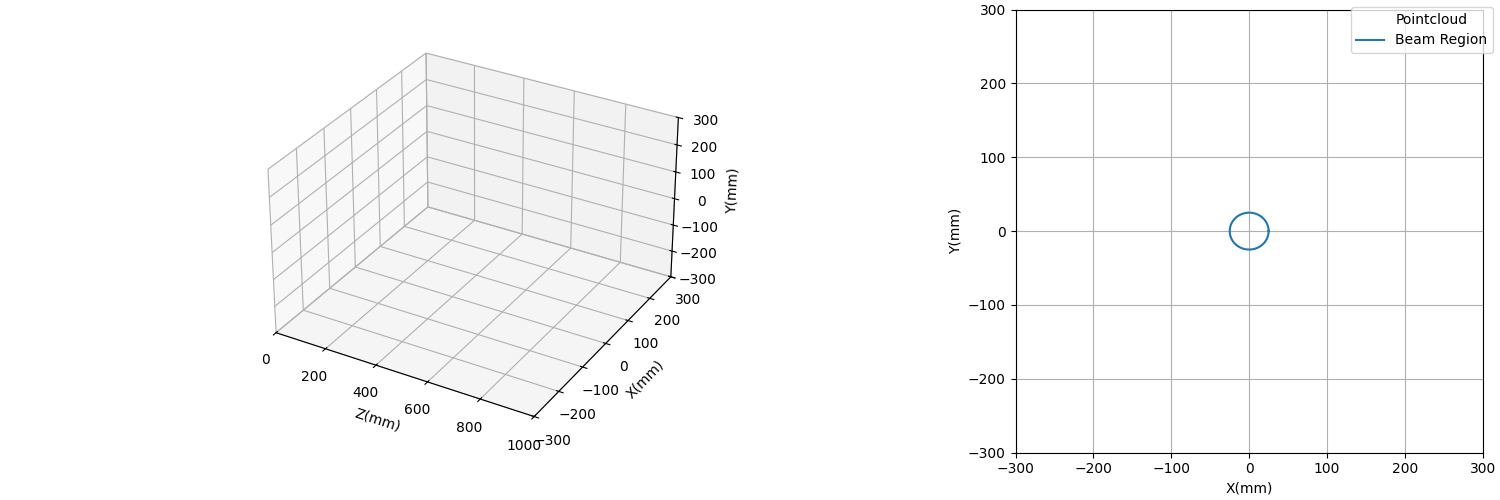

In [ ]:
cloud = point_cloud_from_get(event.get_pads, pad_map, rcnp_map)
hover_text = [f"Pad ID: {int(point[5])}\nX: {point[0]:.3}\nY: {point[1]:.3}\nZ: {point[2]:.3}" for point in cloud.data] # We'll use this later 

fig, axs = plt.subplot_mosaic(
    """
    AAB
    """,
    per_subplot_kw={
        "A": {
            "projection": "3d", 
            "box_aspect": (2,1,1),
            "aspect": "equalxy"
        }
    },
    figsize=(15.0, 5.0),
    constrained_layout=True
)
s3d = axs["A"].scatter(cloud.data[:, 2], cloud.data[:, 0], cloud.data[:, 1], c=cloud.data[:, 3], s=3, label="Pointcloud")
axs["A"].set_xlim3d(0., 1000.0)
axs["A"].set_xlabel("Z(mm)")
axs["A"].set_ylim3d(-300.0, 300.0)
axs["A"].set_ylabel("X(mm)")
axs["A"].set_zlim3d(-300.0, 300.0)
axs["A"].set_zlabel("Y(mm)")
s2d = axs["B"].scatter(cloud.data[:, 0], cloud.data[:, 1], c=cloud.data[:, 3], s=3)
axs["B"].plot(beam_region[:, 0], beam_region[:, 1], label="Beam Region")
axs["B"].set_xlim(-300.0, 300.0)
axs["B"].set_xlabel("X(mm)")
axs["B"].set_ylim(-300.0, 300.0)
axs["B"].set_ylabel("Y(mm)")
axs["B"].grid()
fig.legend()
mplcursors.cursor(s3d).connect("add", lambda sel: sel.annotation.set_text(hover_text[sel.index]))
mplcursors.cursor(s2d).connect("add", lambda sel: sel.annotation.set_text(hover_text[sel.index]))

Above, you should see your point cloud plotted in 3D as well as the X-Y plane (pad plane) projection. The marker color indicates the charge ampltiude of the peak used to make the point in the point cloud. If you hover over one of the points in either plot, you'll see a label which shows the coordinate position as well as the trace and peak number which produced the point. This can be used to pick specific traces to examine

The z-axis is still in Time Buckets. We would like to convert this time axis into a position. To do this we use the reference time of the window and micromegas mesh (i.e. the position of the ends of the detector within the trigger). These values have to be estimated from the data. Typically this is handled by looking for window events (events where the beam reacted with the window), because they typically span the entire volume of the detector. Once you've set these values in your config, run the cell below to re-plot the point cloud with calibrated z-position.

When calibrating we also apply an electric field correction from a Garfield++ simulation of the AT-TPC electric field. This allows us to correct for field non-uniformities, particularly near the edges of the AT-TPC.

<function __main__.<lambda>(sel)>

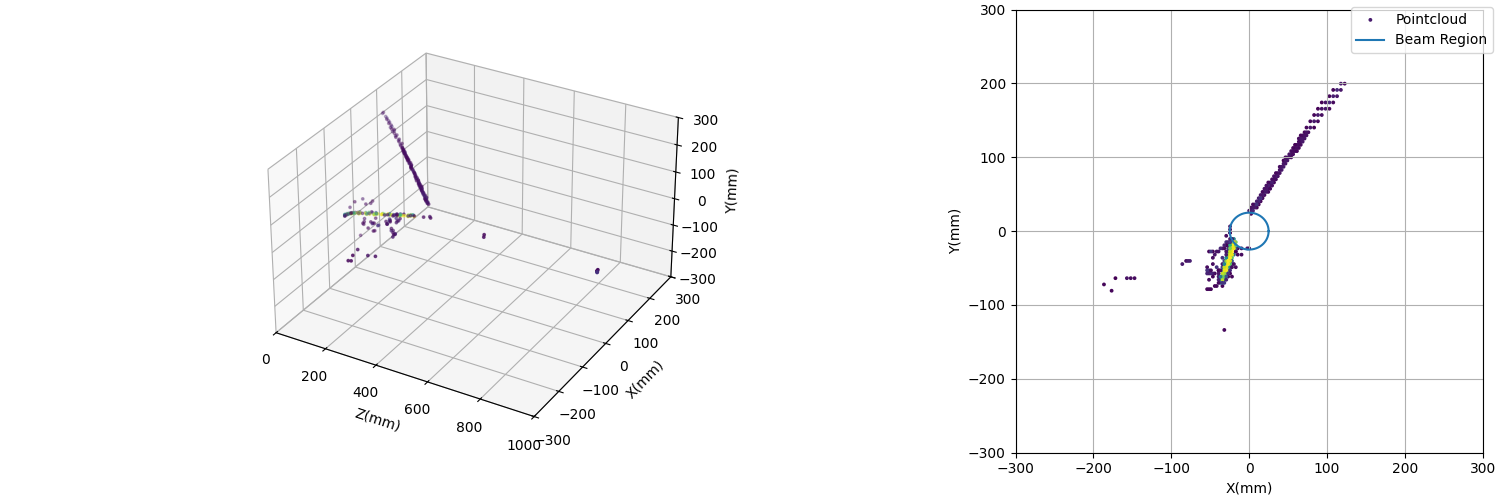

In [ ]:
# Load the correction if requested
corrector = None
if correction_path.exists():
    corrector = create_electron_corrector(correction_path)

calibrate_point_cloud_z(cloud, det_params, efield_correction=corrector)

hover_text = [f"Pad ID: {int(point[5])}\nX: {point[0]:.3}\nY: {point[1]:.3}\nZ: {point[2]:.3}" for point in cloud.data] # We'll use this later 

fig, axs = plt.subplot_mosaic(
    """
    AAB
    """,
    per_subplot_kw={
        "A": {
            "projection": "3d", 
            "box_aspect": (2,1,1),
            "aspect": "equalxy"
        }
    },
    figsize=(15.0, 5.0),
    constrained_layout=True
)
s3d = axs["A"].scatter(cloud.data[:, 2], cloud.data[:, 0], cloud.data[:, 1], c=cloud.data[:, 3], s=3, label="Pointcloud")
axs["A"].set_xlim3d(0., 1000.0)
axs["A"].set_xlabel("Z(mm)")
axs["A"].set_ylim3d(-300.0, 300.0)
axs["A"].set_ylabel("X(mm)")
axs["A"].set_zlim3d(-300.0, 300.0)
axs["A"].set_zlabel("Y(mm)")
s2d = axs["B"].scatter(cloud.data[:, 0], cloud.data[:, 1], c=cloud.data[:, 3], s=3)
axs["B"].plot(beam_region[:, 0], beam_region[:, 1], label="Beam Region")
axs["B"].set_xlim(-300.0, 300.0)
axs["B"].set_xlabel("X(mm)")
axs["B"].set_ylim(-300.0, 300.0)
axs["B"].set_ylabel("Y(mm)")
axs["B"].grid()
fig.legend()
mplcursors.cursor(s3d).connect("add", lambda sel: sel.annotation.set_text(hover_text[sel.index]))
mplcursors.cursor(s2d).connect("add", lambda sel: sel.annotation.set_text(hover_text[sel.index]))

You can re-run the code cells in this Analyzing section to walk through the data sequentially, or select a specific event to look at.

### Conclusion

That is a basic analysis of the traces and the point cloud data! With well tuned parameters, you're now ready to run the phase 1 analysis. Follow the instructions in the README to do this. Once thats done, you can move on to the next stage, generating and identifying clusters within the point clouds.